# Residence Reccommender 
*CS524 Intro to Optimization, 18 December 2021*

Puqian Wang & Sonia Cromp

## Introduction
This is our project about apartments. Here is how we got the idea and why it's useful.

## Setup and Data Generation
We begin with preparing the "standard" dataset - more datasets will be used later in the analysis

In [110]:
import pandas as pd
%load_ext gams_magic 

The gams_magic extension is already loaded. To reload it, use:
  %reload_ext gams_magic


### Resident data
Specify custom data parameters here

In [111]:
%%gams
# DO NOT EDIT ABOVE HERE
# number of residents

scalar num_res /30/;
# stochastisity settings

# beds, baths distribution
# budget
# commute method and time

# DO NOT EDIT BELOW HERE


In [160]:
%%gams
set r /1*100/;
set cr(r);
cr(r) = no;
cr(r)$(ord(r)<=num_res) = yes;
set slot /t1*t5/;
set labels /'nbed', 'nbath', 'budget', 'com_m', 'com_t'/;

parameter big(r, labels);
parameter res(r, labels);

****************************************************
parameter rank_1(r, labels), rank(r, labels);

alias(labels, l);

parameter normalize(r);

loop(r,
rank_1(r, labels) = uniform(0,1);
normalize(r) = sum(labels, rank_1(r, labels));
);
rank(r, labels) = rank_1(r, labels)/normalize(r);

****************************************************

parameter beds;
loop(r,
    beds = normal(2,1);
    if(beds>0,
        big(r, 'nbed') = ceil(beds);
    else
        big(r, 'nbed') = 0;
    );
);

big(r, 'nbath') $ (big(r, 'nbed')>0)= floor(uniform(1, big(r, 'nbed')));
big(r, 'nbath') $ (big(r, 'nbed')=0) = 1;

parameter budgets;
loop(r,
    budgets = normal(1200,200);
    big(r, 'budget') = budgets $ (budgets>=500) + 500 $ (budgets<500);
);

*parameter com_m(r);
*com_m(r) = floor(uniform(1,4))

*$onText

big(r, 'com_m')  = floor(uniform(1,4));
big(r, 'com_m')  $ (big(r, 'com_m')=4) = 3

parameter time_slot(slot)
/t1 5,
 t2 10,
 t3 15,
 t4 20,
 t5 25/;

parameters com_time_prim, com_time;
loop(r,
com_time_prim = floor(normal(15, 5));
com_time $ (com_time_prim<time_slot('t1')) = 1;
com_time $ (com_time_prim>=time_slot('t1') and com_time_prim<time_slot('t2')) = 2;
com_time $ (com_time_prim>=time_slot('t2') and com_time_prim<time_slot('t3')) = 3;
com_time $ (com_time_prim>=time_slot('t3') and com_time_prim<time_slot('t4')) = 4;
com_time $ (com_time_prim>=time_slot('t5') and com_time_prim<time_slot('t5')) = 5;
com_time $ (com_time_prim>=time_slot('t5')) = 6;
big(r, 'com_t') = com_time;
);

res(cr, labels) = big(cr, labels);
display big, rank, normalize;


In [161]:
%gams_pull -d res
%gams_pull -d big
%gams_pull -d rank

In [164]:
print(res.shape, big.shape, rank.shape)
res.head()
print(res)
print(big)

(150, 3) (498, 3) (500, 3)
      r  labels        value
0     1    nbed          2.0
1     1   nbath          1.0
2     1  budget  1011.616664
3     1   com_m          1.0
4     1   com_t          2.0
5     2    nbed          2.0
6     2   nbath          1.0
7     2  budget  1303.142111
8     2   com_m          1.0
9     2   com_t          2.0
10    3    nbed          4.0
11    3   nbath          2.0
12    3  budget  1108.310311
13    3   com_m          2.0
14    3   com_t          2.0
15    4    nbed          2.0
16    4   nbath          1.0
17    4  budget  1494.843227
18    4   com_m          3.0
19    4   com_t          2.0
20    5    nbed          2.0
21    5   nbath          1.0
22    5  budget  1164.172252
23    5   com_m          2.0
24    5   com_t          6.0
25    6    nbed          5.0
26    6   nbath          4.0
27    6  budget  1353.449819
28    6   com_m          1.0
29    6   com_t          6.0
30    7    nbed          3.0
31    7   nbath          1.0
32    7  budget 

In [165]:
len(set(rank['r']))

100

In [166]:
rank.head()

,r,labels,value
0,1,nbed,0.065442
1,1,nbath,0.259169
2,1,budget,0.118997
3,1,com_m,0.276416
4,1,com_t,0.279977


### Apartments data
Because gathering real apartments required some API calls where a credit card is required to sign up and will be charged upon exceeding the quota, this code is commented out and will not work without an API key. However, it is included so as to show how all the data was gathered.

First, gather the apartments themselves

In [167]:
# import requests
# url = "https://zillow-com1.p.rapidapi.com/propertyExtendedSearch"
# headers = {
#     'x-rapidapi-host': "zillow-com1.p.rapidapi.com",
#     'x-rapidapi-key': "" # enter your api key here
#     }

# text = []
# for place in ['fitchburg', 'madison', 'middleton', 'sun prarie', 'verona']:
#     querystring = {"location":f"{place}, wi","home_type":"Condos,Apartments"}
#     response = requests.request("GET", url, headers=headers, params=querystring) # comes back in odd format that isn't quite JSON
#     text.append(response.text)

Second, determine the travel/commute time from each apartment to the CS building by walking, biking and driving

In [168]:
# import json
# import os
# import re

# allapts = []
# dest = '1210 W Dayton St Madison WI 53706'
# api_key = '' # enter your api key here
# url ='https://maps.googleapis.com/maps/api/distancematrix/json?'

# def gettime(source, dest, key, method='driving'):
#     source = re.sub('#', 'unit ', source)
#     # return response object
#     r = requests.get(url + 'origins=' + source +
#                     '&destinations=' + dest +
#                     '&mode=' + method +
#                     '&key=' + api_key)
#     # json method of response object
#     # return json format result
#     return r.json()

In [169]:
# for s in text:
#     # Convert from "almost" JSON to an actual JSON format
#     s = re.sub(f'\[?\d+ items', '', s)
#     s = re.sub(f'(?<=[L\"\de])\n(?!}})', ',\n', s)
#     s = re.sub(f'NULL', '-1', s)
#     s = re.sub(f'(\d+):', '\"\g<1>\":', s)
#     s = re.sub(f"\"props\":\n", '', s)
#     s = re.sub('}', '},', s)
#     s= re.sub(f'\n]\n', f'\n', s)
#     s = s.strip()[:-1] #since an extra comma is at the end

#     contents = json.loads(s)
#     contents.pop('resultsPerPage')
#     contents.pop('totalResultCount')
#     contents.pop('totalPages')

#     df = pd.DataFrame(contents).T
#     df.drop(['listingDateTime', 'listingStatus', 'zpid', 'lotAreaUnit', 'daysOnZillow', 'country', 'currency'], axis=1, inplace=True)

#     source = df['address'].to_list()

#     for m in ['driving', 'walking', 'bicycling']:
#         results = []
#         for i in range(len(source)//25): # API only can process 25 apartments at a time
#             subsource = source[25*i : 25*(i+1)]
#             print(len(subsource))
#             subsourcestr = '|'.join(subsource)
#             r = gettime(subsourcestr, dest, api_key, m)
#             results.append(r)

#         subsource = source[25*(len(source)//25) : ]
#         print(len(subsource))
#         subsourcestr = '|'.join(subsource)
#         r = gettime(subsourcestr, dest, api_key, m)
#         results.append(r)

#         seconds = []
#         for r in results:
#             for e in r['rows']:
#                 seconds.append(e['elements'][0]['duration']['value'])
#         df[m] = seconds
#         df[m] = (df[m]/60).astype(int)

#     df['price'] = df['price']/100
#     allapts.append(df)

# df = pd.concat(allapts)

# df.columns = ['nbath', 'propertyType', 'lotAreaValue', 'address', 'imgSrc', 'budget', 'longitude', 'latitude',
#                     'nbed', 'livingArea', 'hasImage', 'car', 'walk', 'bike']
# df.head()
# df.to_csv('apartments.csv', index=False) # save info

In [170]:
apartments = pd.read_csv('apartments.csv')
apt_data = apartments.drop(['propertyType', 'lotAreaValue', 'address', 'imgSrc', 'longitude', 'latitude',
                'livingArea', 'hasImage'], axis=1)
apt_data['a'] = apt_data.index+1
apt_data = apt_data[['a', 'nbed', 'nbath', 'budget', 'car', 'walk', 'bike']]
apt_data.columns = ['a', 'nbed', 'nbath', 'budget', 'm1', 'm2', 'm3']
# apt_data.drop(['m1', 'm2', 'm3'], axis=1, inplace=True)
apt_data['budget'] = apt_data['budget'].astype(int)
apt_data.set_index('a', inplace=True)
apt_data.head()

,nbed,nbath,budget,m1,m2,m3
a,,,,,,
1,2,2,1700,27,276,78
2,2,2,1980,29,301,83
3,2,2,1960,29,301,83
4,2,2,2100,27,299,88
5,1,1,1850,28,299,88


In [171]:
apt_data.to_csv('apartments_formatted.csv', index=False)

# Primary model
model and data description

residence data:
1. desired nbed, nbath, budget, com_m, com_t
2. nbed = 0 if the resident requires a studio

details:
1. com_t is an integer between 1-5, where 1-> t<5, 2-> 5<=t<10, ... 5-> t>25;
2. com_m is an integer between 1-3, where 1-> drive, 2-> walk, 3-> bike;
3. budget generated by normal distribution, mean=1200, delta=200;
4. extracted from gdx files: small_data, medium_data, large_data;
5. headr: /'nbed', 'nbath', 'budget', 'com_m', 'com_t'/
6. data: data(small/medium/large, headr);
7. small=30, medium=60, large=100;
8. need to figure out ranking -- currently a rand number form uniform(0,1) assigned to each label;

apartments data:
1. should have the same headr;
2. about commute methods: m1 for driving, m2 for walking, m3 for biking.

In [172]:
%%gams
set headr(*);
set a /a1*a63/;

parameter pairs;
pairs = min(card(cr), card(a));

$call csv2gdx apartments_formatted.csv id=Data autoRow=a values=1..lastCol useHeader=y;

* set apt_headr(*);
parameter apt_data(a, headr);


$gdxin apartments_formatted.gdx
$load headr=Dim2
$load apt_data=Data
$gdxin
display apt_data;


In [173]:
%%gams

**********************************************************
$onText
notes on the normalization of budgets/prices:

* for residents, since we know the budget is generated from norm(1200,200), we simply scale it by 600, hence the mean would be 2;
* for apartment prices, we scale it by 600 too.

$offtext
scalar budget_mean "the mean value of the budget, get it from residents_data" /1200/;
* normalize the budget with mean value 2
res(r, 'budget') = 2*res(r, 'budget')/budget_mean;

parameter aptprice(a);
apt_data(a,'budget') = 2*apt_data(a,'budget')/budget_mean;

# display apt_data;
***********************************************************

display res, rank;

set m "m1:drive, m2:walk, m3: drive" /m1*m3/;

parameter apt_com_t(a, m);

$gdxin apartments_formatted.gdx
$load apt_com_t=Data
$gdxin

display apt_data,apt_com_t;

********************** Format data **********************

set r_method(r,m) "include a (resident i, commute method j) pair in a set only if j is the preferred commute method of i";
r_method(r,m) = no;
r_method(r,m) $ (ord(m)=res(r,'com_m')) = yes;

parameter apt_com_t_nm(a,m) "binned commute time - put each commute time into 5-minute interval bins";

set slot /t1*t5/;
parameter time_slot(slot)
/t1 5,
 t2 10,
 t3 15,
 t4 20,
 t5 25/;

apt_com_t_nm(a,m) $ (apt_com_t(a, m)<time_slot('t1')) = 1;
apt_com_t_nm(a,m) $ (apt_com_t(a, m)>=time_slot('t1') and apt_com_t(a, m)<time_slot('t2')) = 2;
apt_com_t_nm(a,m) $ (apt_com_t(a, m)>=time_slot('t2') and apt_com_t(a, m)<time_slot('t3')) = 3;
apt_com_t_nm(a,m) $ (apt_com_t(a, m)>=time_slot('t3') and apt_com_t(a, m)<time_slot('t4')) = 4;
apt_com_t_nm(a,m) $ (apt_com_t(a, m)>=time_slot('t4') and apt_com_t(a, m)<time_slot('t5')) = 5;
apt_com_t_nm(a,m) $ (apt_com_t(a, m)>time_slot('t5')) = 6;

parameter
abs_diff(r,a,headr) "absolute difference between apartment a and and resident r",
abs_diff_cmt(r,a) "absolute difference of commute time between apartment a and resident r";

abs_diff(r,a,'nbed') = abs(apt_data(a, 'nbed')-res(r, 'nbed'));
abs_diff(r,a,'nbath') = abs(apt_data(a, 'nbath')-res(r, 'nbath'));
abs_diff(r,a,'budget') = abs(apt_data(a, 'budget')-res(r, 'budget'));
# abs_diff(r,a,'com_m') = res(r, 'com_m');
# abs_diff(r,a,'com_t') = res(r, 'com_t');
abs_diff_cmt(r,a) = abs(sum(m $ r_method(r,m), apt_com_t_nm(a,m)) -res(r,'com_t'));

display apt_data, abs_diff, abs_diff_cmt;

********************** Model **********************

free variable dis "dissatisfication";

variable rdis(r);

positive variables z(r,a,headr), zm(r,a);

Binary Variable
        b(r,a) "b(r,a)=1 if assign resident r to apartment i"
        d(r,m) "d(r, m)=1 if resident r choose method m";

equations
        obj, calcdis(r),
        bound_1(r) "each apartment gets at most one resident", 
        bound_2(a) "each resident gets at most one apartment", 
        bound_3 "count the number of residents assigned apartments";

obj..
dis =e= 1/num_res * sum(r$(ord(r)<=num_res), rdis(r));

calcdis(r)$(ord(r)<=num_res)..
rdis(r) =e= sum(a, b(r,a) * (rank(r, 'nbed')*abs_diff(r,a,'nbed') + rank(r, 'nbath')*abs_diff(r,a,'nbath') + rank(r, 'budget')*abs_diff(r,a,'budget')))
        + sum(a, b(r,a) * rank(r,'com_t') * abs_diff_cmt(r,a));
* second line is dissatisfaction with commute, first line is dissatisfaction with everything else

bound_1(r)$(ord(r)<=num_res)..
sum(a, b(r,a)) =l= 1;

bound_2(a)..
sum(r$(ord(r)<=num_res), b(r,a)) =l= 1;

bound_3..
sum((r,a)$(ord(r)<=num_res), b(r,a)) =e= pairs;

model primary_model /obj+calcdis+bound_1+bound_2+bound_3/;
solve primary_model using mip minimizing dis;
parameter bl(r, a);
bl(r,a) = b.l(r,a);


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),0.5499,125,1921,MIP,CPLEX,0.095


In [175]:
print(bl)

      r    a value
0     2  a26   1.0
1     3  a42   1.0
2     4  a19   1.0
3     5  a35   1.0
4     6  a40   1.0
5     9  a21   1.0
6    10  a39   1.0
7    12  a55   1.0
8    15   a4   1.0
9    19  a47   1.0
10   20  a23   1.0
11   21   a7   1.0
12   24  a10   1.0
13   25  a53   1.0
14   26  a33   1.0
15   29  a56   1.0
16   30  a58   1.0
17   32  a57   1.0
18   33  a60   1.0
19   34   a6   1.0
20   36   a1   1.0
21   37   a3   1.0
22   38  a16   1.0
23   39  a20   1.0
24   42   a2   1.0
25   45  a59   1.0
26   46  a32   1.0
27   47  a14   1.0
28   48  a52   1.0
29   49  a51   1.0
30   51  a38   1.0
31   53  a30   1.0
32   56   a5   1.0
33   57  a15   1.0
34   62  a11   1.0
35   63  a34   1.0
36   64  a17   1.0
37   65   a9   1.0
38   67  a36   1.0
39   70  a22   1.0
40   71   a8   1.0
41   72  a41   1.0
42   73  a61   1.0
43   74  a18   1.0
44   75  a27   1.0
45   79  a48   1.0
46   80  a13   1.0
47   82  a54   1.0
48   83  a29   1.0
49   84  a62   1.0
50   85  a49   1.0
51   86  a43

Visualize, discuss

In [176]:
import matplotlib.pyplot as plt
!pip install geopandas
import geopandas as gpd
from shapely.geometry import Point

In [177]:
geo = [Point(xy) for xy in zip(apartments['longitude'], apartments['latitude'])]
geo[:3]

In [178]:
cs = gpd.GeoDataFrame(['CS Building'], geometry=[Point((-89.40656814970647, 43.0712547367913))]) # location of CS bldng from Google Maps
cs

,0,geometry
0,CS Building,POINT (-89.40657 43.07125)


In [179]:
gdf = gpd.GeoDataFrame(apartments, geometry=geo)
gdf.head()

,nbath,propertyType,lotAreaValue,address,imgSrc,budget,longitude,latitude,nbed,livingArea,hasImage,car,walk,bike,geometry
0,2,CONDO,-1.0,"257 Talon Pl, Sun Prairie, WI 53590",https://photos.zillowstatic.com/fp/68472cee03d...,1700.0,-89.224850,43.179280,2,1414,True,27,276,78,POINT (-89.22485 43.17928)
1,2,CONDO,-1.0,"252 S Musket Ridge Dr APT 1, Sun Prairie, WI 5...",https://photos.zillowstatic.com/fp/7fcf99be6a1...,1980.0,-89.198040,43.180622,2,1196,True,29,301,83,POINT (-89.19804 43.18062)
2,2,CONDO,-1.0,"252 S Musket Ridge Dr APT 3, Sun Prairie, WI 5...",https://photos.zillowstatic.com/fp/b5c4656b9a0...,1960.0,-89.198040,43.180622,2,1068,True,29,301,83,POINT (-89.19804 43.18062)
3,2,CONDO,-1.0,"972 Chandler Ln, Sun Prairie, WI 53590",https://photos.zillowstatic.com/fp/7ee36c3aaba...,2100.0,-89.228294,43.197790,2,1606,True,27,299,88,POINT (-89.22829 43.19779)
4,1,CONDO,-1.0,"1300 School St APT 204, Sun Prairie, WI 53590",https://photos.zillowstatic.com/fp/fccb02ddbd5...,1850.0,-89.231320,43.199596,1,1316,True,28,299,88,POINT (-89.23132 43.19960)


In [180]:
# !wget https://www2.census.gov/geo/tiger/TIGER2019/COUSUB/tl_2019_55_cousub.zip
# !unzip tl_2019_55_cousub.zip

In [181]:
map = gpd.read_file('./tl_2019_55_cousub.shp')
maplat = map.INTPTLAT.apply(lambda x: x[1:]).astype(float)
maplon = map.INTPTLON.astype(float)

In [183]:
%gams_pull -d bl
bl.shape # so we know all 30 residents were given an apartment
print(bl)

      r    a value
0     1  a37   1.0
1     2  a24   1.0
2     3  a50   1.0
3     4  a59   1.0
4     5  a63   1.0
5     6   a3   1.0
6     7  a31   1.0
7     8  a43   1.0
8     9  a23   1.0
9    10  a26   1.0
10   11  a36   1.0
11   12  a60   1.0
12   13  a38   1.0
13   14  a62   1.0
14   15   a8   1.0
15   16   a5   1.0
16   17  a30   1.0
17   18  a35   1.0
18   19  a18   1.0
19   20  a45   1.0
20   21  a53   1.0
21   22  a61   1.0
22   23  a17   1.0
23   24  a20   1.0
24   25   a1   1.0
25   26  a51   1.0
26   27  a54   1.0
27   28  a21   1.0
28   29  a52   1.0
29   30  a19   1.0
30   32  a57   1.0
31   33  a60   1.0
32   34   a6   1.0
33   36   a1   1.0
34   37   a3   1.0
35   38  a16   1.0
36   39  a20   1.0
37   42   a2   1.0
38   45  a59   1.0
39   46  a32   1.0
40   47  a14   1.0
41   48  a52   1.0
42   49  a51   1.0
43   51  a38   1.0
44   53  a30   1.0
45   56   a5   1.0
46   57  a15   1.0
47   62  a11   1.0
48   63  a34   1.0
49   64  a17   1.0
50   65   a9   1.0
51   67  a36

In [138]:
#get the set of apartments that were given to residents
s = set(bl['a'].apply(lambda x: int(x[1:])-1))
gdf['a'] = gdf.index
assigned = gdf[gdf['a'].apply(lambda x: x in set(s))][['geometry']]
notassigned = gdf[gdf['a'].apply(lambda x: x not in set(s))][['geometry']]
print(assigned.shape, notassigned.shape)

(51, 1) (12, 1)


In [139]:
assigned

,geometry
0,POINT (-89.22485 43.17928)
1,POINT (-89.19804 43.18062)
3,POINT (-89.22829 43.19779)
4,POINT (-89.23132 43.19960)
5,POINT (-89.43127 43.01883)
6,POINT (-89.42986 43.01363)
7,POINT (-89.42924 43.01941)
8,POINT (-89.43127 43.01883)
9,POINT (-89.42565 42.99980)
10,POINT (-89.39847 43.00855)


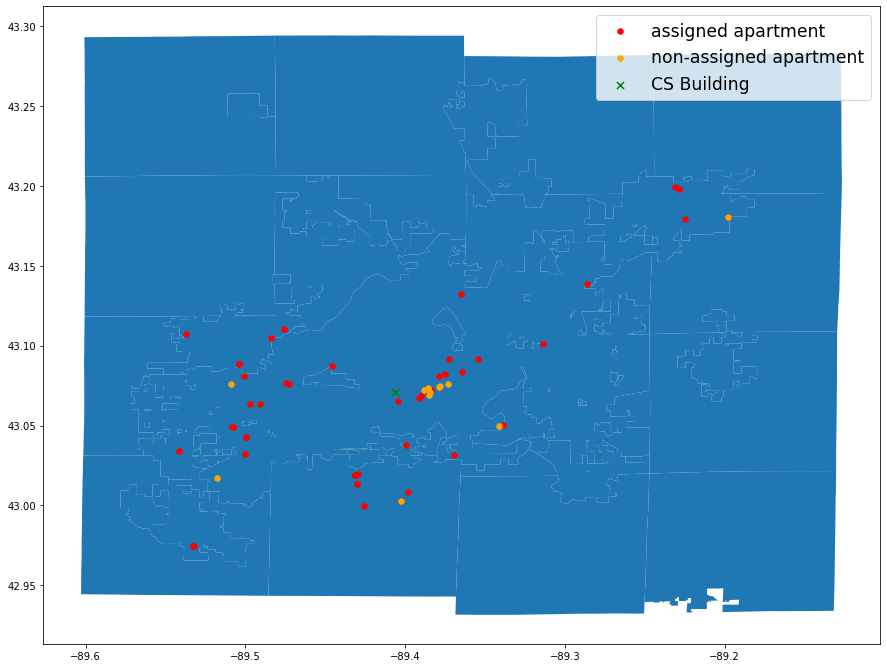

In [140]:
fig, ax = plt.subplots(figsize=(15,15))
map[(maplat < 43.25) & (maplat >42.95) & (maplon > -89.6) & (maplon < -89.1)].plot(ax=ax)
assigned.plot(ax=ax, markersize=30, color='red', label='assigned apartment')
notassigned.plot(ax=ax, markersize=30, color='orange', label='non-assigned apartment')
cs.plot(ax=ax, markersize=50, color='green', marker='x', label='CS Building')
plt.legend(fontsize='xx-large')

Note the area of apartments right around where the capitol is downtown. Likely, these are very expensive apartments that are outside a student budget, which is why they weren't assigned.

# Tradeoff model

In [141]:
%%gams 
alias(r2,r);
alias(cr2,cr);
scalars 
        lambda "priority between minimizing average dissatisfaction and max dissatisfaction" /0.4/,
        infty "stand-in for infinity in equations" /1e5/;

free variables 
        avgdis "total dissatisfication",
        maxdis "dissatisfaction of most dissatisfied resident",
        cdis "combined dissatisfaction from average dissatisfaction and the most dissatisfied resident";
    
positive variables disAON(r) "dissatisfaction all or nothing - equals dis(r) if r is most dissatisfied resident and 0 otherwise";

binary variables
        isMax(r) "is the resident who is most dissatisfied",
        isntMax(r) "isnt the resident who is most dissatisfied",
        worse(r,r2) "only able to be 1 if r is at least as dissatisfied as r2",
        better(r, r2) "must be 1 if r is less dissatisfied (=more satisfied) than r2";

equations
        calcavgdis "average dissatisfaction",
        calcmaxdis "dissatisfaction of most dissatisfied resident",
        findbetter(r,r2) "determine if r is happier than r2",
        findworse(r, r2) "if r is less happy from r2",
        calcIsntmax(r) "determine if r can potentially be the most dissatisfied resident",
        calcIsmax(r) "determine if r will be selected as most dissatisfied",
        mostdissed "choose only one resident as the most dissatisfied",
        disaon_lolim1(r) "disAON is 0 if r isnt most dissatisfied",
        disaon_lolim2(r) "disAON isnt greater than dis(r)",
        disaon_hilim(r) "disAON is dis(r) if r is most dissatisfied";

findbetter(cr, cr2)..
better(cr, cr2) =g= (rdis(cr2) - rdis(cr)) / infty;

findworse(cr, cr2)..
worse(cr, cr2) + better(cr, cr2) =e= 1;

calcIsntmax(cr)..
isntMax(cr) =g= 1/num_res * (-sum(cr2, worse(cr,cr2) ) + card(cr));

calcIsmax(cr)..
isMax(cr) + isntMax(cr) =e= 1;

mostdissed..
sum(cr, isMax(cr)) =e= 1;

disaon_lolim1(cr)..
disAON(cr) =l= infty * isMax(cr);

disaon_lolim2(cr)..
0 =l= rdis(cr) - disAON(cr);

disaon_hilim(cr)..
rdis(cr) - disAON(cr) =l= infty * (1-isMax(cr));

calcavgdis..
avgdis =e= (1/card(cr)) * sum(cr, rdis(cr));

calcmaxdis..
maxdis =e= sum(cr, disAON(cr));

obj..
cdis =e= lambda*avgdis + (1-lambda)*maxdis;

model tra_model /obj+calcdis+bound_1+bound_2+bound_3+findbetter+findworse+calcIsntmax+calcIsmax+mostdissed+disaon_lolim1+disaon_lolim2+disaon_hilim+calcavgdis+calcmaxdis+obj/;
solve tra_model using mip min cdis;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),1.0364,2078,3813,MIP,CPLEX,1.277


*Varying lambda*

You will observe

In [142]:
%%gams
lambda=1;
solve tra_model using mip min cdis;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),0.5326,2078,3813,MIP,CPLEX,0.184


In [143]:
%%gams
lambda=0.99;
solve tra_model using mip min cdis;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),0.542,2078,3813,MIP,CPLEX,0.557


In [144]:
%%gams
lambda=0;
solve tra_model using mip min cdis;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),1.3596,2078,3813,MIP,CPLEX,0.315


In [145]:
%%gams
lambda=.7;
solve tra_model using mip min cdis;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Integer (8),0.794,2078,3813,MIP,CPLEX,0.497


In [146]:
%%gams
lambda=.3;
solve tra_model using mip min cdis;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),1.1172,2078,3813,MIP,CPLEX,0.823


*Data scenarios*

First, suppose some resident 100% wants a one-bed apartment and doesn't care about anything else. Let's simulate this scenario, then check if this resident's assigned apartment is indeed a 1-bedroom.

In [147]:
%%gams
*reset lambda
lambda=0.5;
* one abnormal resident who 100% only wants a one-bed apartment
parameter rank1old(labels);
rank1old(labels) = rank('1', labels);
rank('1', labels) = 0;
rank('1', 'nbed') = 1;
solve tra_model using mip minimizing cdis;
rank('1', labels) = rank1old(labels);
parameter bl(r,a);
bl(r,a) = b.l(r,a);

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Integer (8),0.9457,2078,3813,MIP,CPLEX,0.855


In [148]:
%gams_pull -d bl
bl.iloc[0]['a']
# which apartment number did the resident get?

'a29'

In [149]:
apartments.loc[28] #because GAMS uses indexing starting from 1 and python starting from 0

nbath                                                           2
propertyType                                                CONDO
lotAreaValue                                                 -1.0
address                 351 W Wilson St UNIT 4, Madison, WI 53703
imgSrc          https://photos.zillowstatic.com/fp/14a473c283b...
budget                                                     3300.0
longitude                                              -89.385315
latitude                                                43.069065
nbed                                                            1
livingArea                                                    894
hasImage                                                     True
car                                                             5
walk                                                           24
bike                                                            8
geometry                     POINT (-89.38531500000001 43.069065)
a         

Apartment 28 is indeed a 1-bedroom!

Next, let's figure that everyone has the exact same apartment preferences and see what happens. Make everyone have the same preferences as the first resident originally did, which are as follows:

In [64]:
res[res['r']=='1'] # what they want

,r,labels,value
0,1,nbed,1.0
1,1,nbath,1.0
2,1,budget,1415.564452
3,1,com_m,2.0
4,1,com_t,4.0


In [65]:
rank[rank['r']=='1'] #how badly they want each of these things

,r,labels,value
0,1,nbed,0.305183
1,1,nbath,0.350371
2,1,budget,0.163925
3,1,com_m,0.006297
4,1,com_t,0.174224


In [66]:
%%gams
parameter rankold(r, labels);
parameter resold(r, labels);
rankold(r, labels) = rank(r, labels);
resold(r, labels) = res(r, labels);
rank(r, labels) = rank('1', labels);
res(r, labels) = res('1', labels);
solve tra_model using mip minimizing cdis;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),0.8554,2078,3813,MIP,CPLEX,0.807


This is a fairly large loss amount (0.84), which makes sense because it's hard to please everybody when they all want the same thing even if that thing is relatively reasonable. Now, we can try making everybody want the same thing that's relatively strange.

In [67]:
%%gams
rank(r, labels) = 0;
rank(r, 'budget') = 0.5;
rank(r, 'nbed') = 0.5;
# * be sure to normalize budget again
res(r, 'budget') = 100;
res(r, 'budget') = 2* res(r, 'budget')  / budget_mean;
res(r, 'nbed') = 5;

abs_diff(r,a,'nbed') = abs(apt_data(a, 'nbed')-res(r, 'nbed'));
abs_diff(r,a,'budget') = abs(apt_data(a, 'budget')-res(r, 'budget'));
solve tra_model using mip minimizing cdis;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),3.1223,2078,3813,MIP,CPLEX,4.264


The model takes a long time to solve and gets the giant objective value of 3.12. So, probably nobody is all that happy in this scenario.

Next, use the large dataset of 100 residents to see what happens when only some people are able to recieve an apartment.

In [68]:
%%gams
cr(r) = yes;
res(r, labels) = big(r, labels);
scalar old_num;
old_num = num_res;
num_res=100;
pairs = min(card(cr), card(a));
alias(cr2, cr);
res(r, 'budget') = 2* res(r, 'budget')  / budget_mean;
abs_diff(r,a,'nbed') = abs(apt_data(a, 'nbed')-res(r, 'nbed'));
abs_diff(r,a,'nbath') = abs(apt_data(a, 'nbath')-res(r, 'nbath'));
abs_diff(r,a,'budget') = abs(apt_data(a, 'budget')-res(r, 'budget'));
abs_diff_cmt(r,a) = abs(sum(m $ r_method(r,m), apt_com_t_nm(a,m)) -res(r,'com_t'));
solve tra_model using mip minimizing cdis;
bl(r,a) = b.l(r,a);
parameter rdis_100(r);
rdis_100(r) = rdis.l(r);

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),10.294,20768,26703,MIP,CPLEX,5.458


In [71]:
%gams_pull -d bl
%gams_pull -d rdis_100
bl.shape
pd.options.display.max_columns = None
pd.options.display.max_rows = None
print(bl)
print(rdis_100)

      r    a value
0     1  a23   1.0
1     3  a40   1.0
2     5  a47   1.0
3     6  a56   1.0
4     7  a51   1.0
5     9  a20   1.0
6    10  a29   1.0
7    13  a24   1.0
8    14  a22   1.0
9    16  a38   1.0
10   17  a35   1.0
11   19  a58   1.0
12   20  a32   1.0
13   21  a18   1.0
14   22  a44   1.0
15   23   a3   1.0
16   24  a16   1.0
17   27  a34   1.0
18   29  a26   1.0
19   30  a48   1.0
20   31  a49   1.0
21   33  a37   1.0
22   37  a39   1.0
23   39  a45   1.0
24   41  a61   1.0
25   44  a46   1.0
26   45  a41   1.0
27   48  a11   1.0
28   49  a19   1.0
29   51  a63   1.0
30   55  a21   1.0
31   57   a4   1.0
32   58  a12   1.0
33   59   a8   1.0
34   60  a27   1.0
35   64  a52   1.0
36   65  a10   1.0
37   66  a36   1.0
38   68  a30   1.0
39   69  a42   1.0
40   70   a6   1.0
41   71  a13   1.0
42   73   a2   1.0
43   74   a7   1.0
44   75  a14   1.0
45   76   a9   1.0
46   77  a59   1.0
47   78  a60   1.0
48   81  a28   1.0
49   84  a43   1.0
50   87  a25   1.0
51   88  a55

So, only 63 residents were able to get apartments. The loss is very high since many people are unhappy for not recieving any apartment.

Now, reset things in order to show the stochastic tradeoff model.

In [72]:
%%gams
num_res=old_num;
cr(r) = no;
cr(r)$(ord(r)<=num_res) = yes;
res(r, labels) = resold(r, labels);

In [73]:
%gams_pull -d old_num
old_num

,value
0,30.0


# Stochastic tradeoff model
stochastic model details:

* match every resident registered in the past week to current apartments every Mon;
* each resident is assigned a register time, from 1-7, where 1 -> 1 day ago, 2 -> 2 days ago, etc.;
* for each register time, there is a pobability that the resident would quit before the matching process;
* this probability is set manually;
* if a resident quits, his/hers dissatisfication is set to 0; 
* the rest of the model remain unchanged;

In [74]:
%%gams
set t week days /1*7/;

parameter regtim(r) "the registration time of each resident r";

regtim(r) = ceil(uniform(0,7));

parameter quitprob(t) "the probability of quitting on the t-th day after registration"
/1 0.05
 2 0.05
 3 0.7
 4 0.9
 5 0.12
 6 0.15
 7 0.18/;

equation calcErdis(r,t) "calculate the expected dissatisfication of resident r";

calcErdis(r,t) $ (ord(t)=regtim(r))..
rdis(r) =e= (1-quitprob(t))*sum(a, b(r,a) * (rank(r, 'nbed')*abs_diff(r,a,'nbed') + rank(r, 'nbath')*abs_diff(r,a,'nbath') + rank(r, 'budget')*abs_diff(r,a,'budget')))
        + (1-quitprob(t))*sum(a, b(r,a) * rank(r,'com_t')*abs_diff_cmt(r,a));
* second line is Expected dissatisfaction with commute, first line is expected dissatisfaction with everything else

model stotra_model /obj, calcavgdis, calcmaxdis, calcErdis, findbetter, findworse, calcIsntmax,
                calcIsmax, mostdissed, disaon_lolim1, disaon_lolim2, disaon_hilim, bound_1, 
                bound_2, bound_3/;
solve stotra_model using mip min cdis;
bl(r,a) = b.l(r,a);

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),IntegerInfeasible (10),NA,2148,8293,MIP,CPLEX,0.071


In [75]:
%%gams
lambda=1;
solve stotra_model using mip min cdis;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),IntegerInfeasible (10),NA,2148,8293,MIP,CPLEX,0.047


In [ ]:
%%gams
lambda=.7;
solve stotra_model using mip min cdis;

In [ ]:
%%gams
lambda=.3;
solve stotra_model using mip min cdis;

In [ ]:
%%gams
lambda=0;
solve stotra_model using mip min cdis;

abnormal resident

In [ ]:
%%gams
*reset lambda
lambda=0.5;
* one abnormal resident who 100% only wants a one-bed apartment
parameter rank1old(labels);
rank1old(labels) = rank('1', labels);
rank('1', labels) = 0;
rank('1', 'nbed') = 1;
solve stotra_model using mip minimizing cdis;
rank('1', labels) = rank1old(labels);
parameter bl(r,a);
bl(r,a) = b.l(r,a);

everyone has the same request and ranking

In [ ]:
res[res['r']=='1'] # what they want
rank[rank['r']=='1'] #how badly they want each of these things

In [ ]:
%%gams
parameter rankold(r, labels);
parameter resold(r, labels);
rankold(r, labels) = rank(r, labels);
resold(r, labels) = res(r, labels);
rank(r, labels) = rank('1', labels);
res(r, labels) = res('1', labels);
solve stotra_model using mip minimizing cdis;

everyone has the same wierd preference

In [ ]:
%%gams
rank(r, labels) = 0;
rank(r, 'budget') = 0.5;
rank(r, 'nbed') = 0.5;
# * be sure to normalize budget again
res(r, 'budget') = 100;
res(r, 'budget') = 2* res(r, 'budget')  / budget_mean;
res(r, 'nbed') = 5;

abs_diff(r,a,'nbed') = abs(apt_data(a, 'nbed')-res(r, 'nbed'));
abs_diff(r,a,'budget') = abs(apt_data(a, 'budget')-res(r, 'budget'));
solve stotra_model using mip minimizing cdis;

100 residents data set

In [ ]:
%%gams
cr(r) = yes;
res(r, labels) = big(r, labels);
scalar old_num;
old_num = num_res;
num_res=100;
pairs = min(card(cr), card(a));
alias(cr2, cr);
res(r, 'budget') = 2* res(r, 'budget')  / budget_mean;
abs_diff(r,a,'nbed') = abs(apt_data(a, 'nbed')-res(r, 'nbed'));
abs_diff(r,a,'nbath') = abs(apt_data(a, 'nbath')-res(r, 'nbath'));
abs_diff(r,a,'budget') = abs(apt_data(a, 'budget')-res(r, 'budget'));
abs_diff_cmt(r,a) = abs(sum(m $ r_method(r,m), apt_com_t_nm(a,m)) -res(r,'com_t'));
solve tra_model using mip minimizing cdis;
bl(r,a) = b.l(r,a);

reset data

In [ ]:
%%gams
num_res=old_num;
cr(r) = no;
cr(r)$(ord(r)<=num_res) = yes;
res(r, labels) = resold(r, labels);